# Hydropandas and Pastas

This notebook demonstrates how hydropandas can be used to build Pastas Models. [Pastas](https://pastas.readthedocs.io) is a Python package that can be used to simulate and analyze groundwater time series. One of the biggest challenges when making a Pastas Model is to find a valid dataset. The Hydropandas packages can be used to obtain such a dataset. This notebook shows how to build a simple pastas model from Dutch data. 

1. [Groundwater observations](#Groundwater-observations)
2. [Meteo observations](#Meteo-observations)
3. [Pastas model](#Pastas-model)
4. [Surface water observations](#Surface-water-observations)
5. [Pastastore](#Pastastore)

In [14]:
import hydropandas as hpd
import pastas as ps
import pastastore as pst

import logging

ps.set_log_level("ERROR")
hpd.util.get_color_logger("INFO")

print(hpd.__version__)
print(ps.__version__)

SystemError: initialization of _internal failed without raising an exception

## Groundwater observations

First we read the groundwater level observation using the `from_dino` function of a `GroundwaterObs` object. The code below reads the groundwater level timeseries from a csv file in the data directory.

In [2]:
gw_levels = hpd.GroundwaterObs.from_dino(r"data/B49F0555001_1.csv")

Note that `gw_levels` is a `GroundwaterObs` object. This is basically a pandas DataFrame with additional methods and attributes related to groundwater level observations. We can print `gw_levels` to see all of its properties.

In [3]:
print(gw_levels)

GroundwaterObs B49F0555-001
-----metadata------
name : B49F0555-001 
x : 94532.0 
y : 399958.0 
filename : B49F0555001_1 
source : dino 
unit : m NAP 
monitoring_well : B49F0555 
tube_nr : 1.0 
screen_top : -0.75 
screen_bottom : -1.75 
ground_level : -0.61 
tube_top : -0.15 
metadata_available : True 

-----time series------
            stand_m_tov_nap   locatie  filternummer  stand_cm_tov_mp   
peildatum                                                              
2003-02-14            -0.64  B49F0555             1             49.0  \
2003-02-26            -0.71  B49F0555             1             56.0   
2003-03-14            -0.81  B49F0555             1             66.0   
2003-03-28            -0.92  B49F0555             1             77.0   
2003-04-14            -0.81  B49F0555             1             66.0   
...                     ...       ...           ...              ...   
2013-10-26            -0.71  B49F0555             1             56.0   
2013-10-27            -0

The `GroundwaterObs` object comes with its own plot methods, to quickly visualize the data:

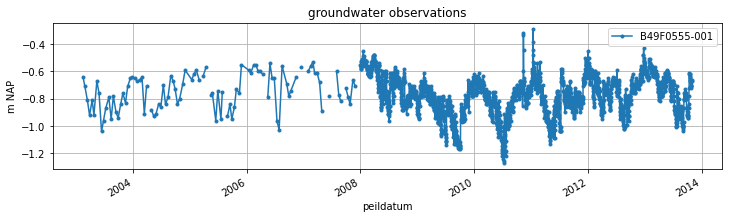

In [4]:
ax = gw_levels["stand_m_tov_nap"].plot(
    figsize=(12, 3),
    marker=".",
    grid=True,
    label=gw_levels.name,
    legend=True,
    ylabel="m NAP",
    title="groundwater observations",
)

## Meteo observations
We can obtain evaporation and precipitation data from the knmi using the `from_knmi_nearest_xy` method in hydropandas. For a given set of (x,y) coordinates it will find the closest KNMI meteostation and download the data. If there are missing measurements they are filled automatically using the value of a nearby station.

In [11]:
evaporation = hpd.EvaporationObs.from_knmi(
    xy=(gw_levels.x, gw_levels.y),
    meteo_var="EV24",
    start=gw_levels.index[0],
    end=gw_levels.index[-1],
    fill_missing_obs=True,
)
precipitation = hpd.PrecipitationObs.from_knmi(
    xy=(gw_levels.x, gw_levels.y),
    start=gw_levels.index[0],
    end=gw_levels.index[-1],
    fill_missing_obs=True,
)

INFO:hydropandas.io.knmi:get KNMI data from station nearest to coordinates (94532.0, 399958.0) and meteovariable EV24
INFO:hydropandas.io.knmi:download knmi EV24 data from station 340-WOENSDRECHT between 2003-02-14 00:00:00 and 2013-10-30 00:00:00
INFO:hydropandas.io.knmi:no measurements found for station 340-WOENSDRECHT between 2003-02-14 00:00:00 and 2013-10-30 00:00:00
INFO:hydropandas.io.knmi:station 340 has no measurements between 2003-02-14 00:00:00 and 2013-10-30 00:00:00
INFO:hydropandas.io.knmi:trying to get measurements from nearest station
INFO:hydropandas.io.knmi:download knmi EV24 data from station 323-WILHELMINADORP between 2003-02-14 00:00:00 and 2013-10-30 00:00:00
INFO:hydropandas.io.knmi:station 323 has 3 missing measurements
INFO:hydropandas.io.knmi:trying to fill 3 measurements with station [310]
INFO:hydropandas.io.knmi:download knmi EV24 data from station 310-VLISSINGEN between 2003-02-14 00:00:00 and 2013-10-30 00:00:00
INFO:hydropandas.io.knmi:get KNMI data from

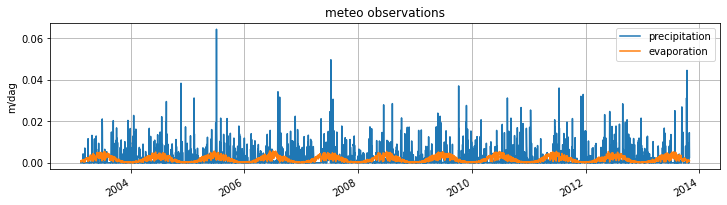

In [12]:
ax = precipitation["RH"].plot(label="precipitation", legend=True, figsize=(12, 3))
evaporation["EV24"].plot(
    ax=ax,
    label="evaporation",
    legend=True,
    grid=True,
    ylabel="m/dag",
    title="meteo observations",
)

## Pastas model

Now that we have groundwater observations and meteo data we can create a Pastas model.

In [13]:
ml = ps.Model(gw_levels["stand_m_tov_nap"], name=gw_levels.name)

# Add the recharge data as explanatory variable
ts1 = ps.RechargeModel(
    precipitation["RH"].resample("D").first(),
    evaporation["EV24"].resample("D").first(),
    ps.Gamma(),
    name="rainevap",
    settings=("prec", "evap"),
)

ml.add_stressmodel(ts1)

ml.solve(tmin="2009")

NameError: name 'ps' is not defined

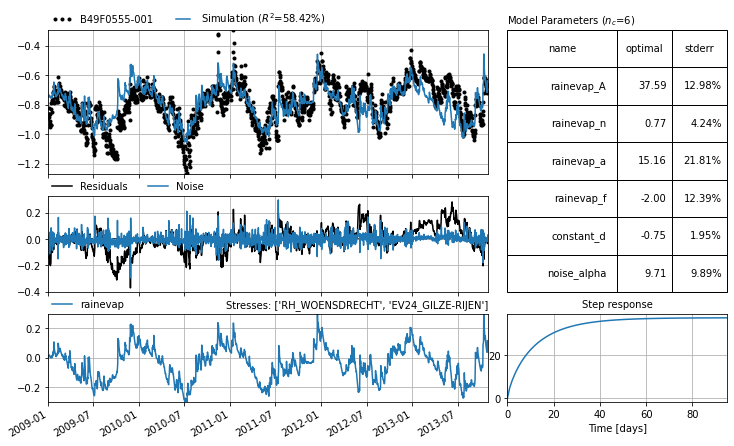

In [ ]:
ml.plots.results(figsize=(10, 6))

## Surface water observations

Our model is not always able to simulate the groundwater level accurately. Maybe it will improve if we add surface water observations. The code below is used to read the surface water level timeseries from a csv file in the data directory.

In [15]:
river_levels = hpd.WaterlvlObs.from_dino(r"data/P43H0001.csv")

INFO:hydropandas.io.dino:reading -> P43H0001


We can plot the data together with the groundwater levels.

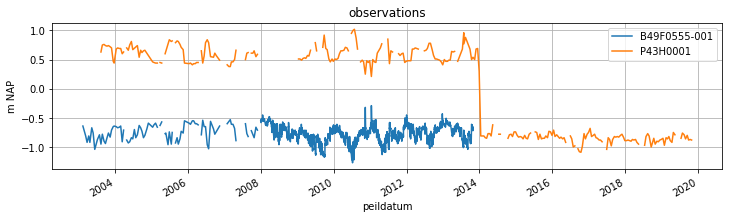

In [16]:
ax = gw_levels["stand_m_tov_nap"].plot(
    figsize=(12, 3),
    label=gw_levels.name,
    ylabel="m NAP",
    title="observations",
    legend=True,
)
river_levels["stand_m_tov_nap"].plot(
    ax=ax, grid=True, label=river_levels.name, legend=True
)

As can be observed in the plot above, there is a downward shift in the surface water levels at the end of 2014. Clearly something went wrong with the registration of the river levels. We assume that the negative values from the end of 2014 onwards are correct. The positive values were registered incorrectly (missing a minus sign). We fix the timeseries by updating the 'stand_m_tov_nap' column of the `WaterlvlObs` object named `river_levels`. 

In [17]:
river_levels["stand_m_tov_nap"] = river_levels["stand_m_tov_nap"].abs() * -1

Now we plot the timeseries again, to see if the applied fix looks reasonable.

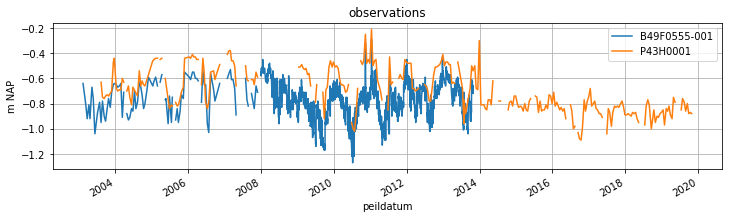

In [18]:
ax = gw_levels["stand_m_tov_nap"].plot(
    figsize=(12, 3),
    label=gw_levels.name,
    ylabel="m NAP",
    title="observations",
    legend=True,
)
river_levels["stand_m_tov_nap"].plot(
    ax=ax, grid=True, label=river_levels.name, legend=True
)

Now we add the river levels as an external stress in the pastas model.

Fit report B49F0555-001                 Fit Statistics
nfev    29                     EVP               77.75
nobs    1764                   R2                 0.78
noise   True                   RMSE               0.07
tmin    2009-01-01 00:00:00    AIC           -11464.85
tmax    2013-10-30 00:00:00    BIC           -11426.52
freq    D                      Obj                1.32
warmup  3650 days 00:00:00     ___                    
solver  LeastSquares           Interp.              No

Parameters (7 optimized)
                   optimal    stderr     initial  vary
rainevap_A     1048.222030   ±77.38%  201.185004  True
rainevap_n        0.595461    ±3.79%    1.000000  True
rainevap_a    10000.000000  ±162.04%   10.000000  True
rainevap_f       -0.941865   ±13.75%   -1.000000  True
waterlevel_d      0.303033   ±13.32%    0.161028  True
constant_d       -1.003024   ±12.27%   -0.774436  True
noise_alpha       4.760376    ±7.38%    1.000000  True

Warnings! (2)
Parameter 'rainevap_a' o

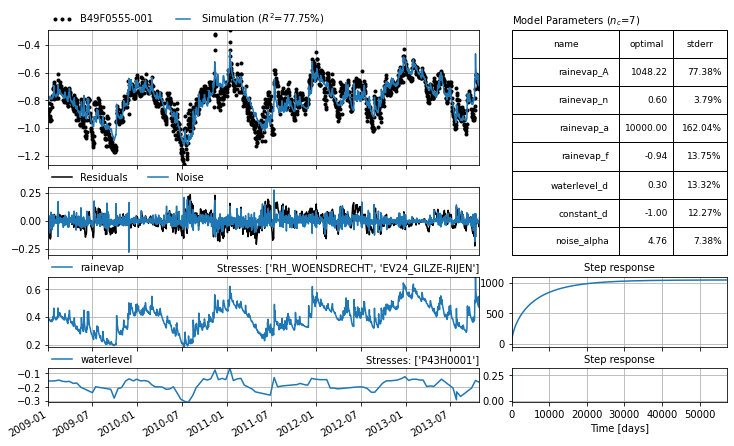

In [ ]:
w = ps.StressModel(
    river_levels["stand_m_tov_nap"].resample("D").first(),
    rfunc=ps.One(),
    name="waterlevel",
    settings="waterlevel",
)
ml.add_stressmodel(w)
ml.solve(tmin="2009")

ml.plots.results(figsize=(10, 6))

We can see that the evp has increased when we've added the water level stress, does this mean that the model improved? Please have a look at the [pastas documentation](https://pastas.readthedocs.io) for more information on this subject.

## Pastastore

We can also use the hydropandas package to create a PastaStore with multiple observations. A Pastastore is a combination of observations, stresses and pastas time series models. More information on the Pastastore can be found [here](https://pastastore.readthedocs.io).

#### Groundwater observations

First we read multiple observations from a directory with dino groundwater measurements. We store them in an ObsCollection object named `oc_dino`.

In [19]:
extent = [117850, 117980, 439550, 439700]  # Schoonhoven zuid-west
dinozip = "data/dino.zip"
oc_dino = hpd.read_dino(dirname=dinozip, keep_all_obs=False)
oc_dino = oc_dino.loc[
    ["B58A0092-004", "B58A0092-005", "B58A0102-001", "B58A0167-001", "B58A0212-001"]
]
oc_dino

INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B02H0092001_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B02H1007001_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B04D0032002_1.csv
INFO:root:not added to collection -> Grondwaterstanden_Put/B04D0032002_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B27D0260001_1.csv
INFO:root:not added to collection -> Grondwaterstanden_Put/B27D0260001_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B33F0080001_1.csv


INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B33F0080002_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B33F0133001_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B33F0133002_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B37A0112001_1.csv
INFO:root:not added to collection -> Grondwaterstanden_Put/B37A0112001_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B42B0003001_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B42B0003002_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B42B0003003_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B42B0003004_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B58A0092004_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B58A0092005_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B58A0102001_1.csv
INFO:hydropandas.io.dino:reading -> Grondwaterstanden_Put/B58A0167001_1.csv
INFO:hydrop

,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
B58A0092-004,186924.0,372026.0,Grondwaterstanden_Put/B58A0092004_1.csv,dino,m NAP,B58A0092,4.0,-115.23,-117.23,29.85,29.61,True,GroundwaterObs B58A0092-004 -----metadata-----...
B58A0092-005,186924.0,372026.0,Grondwaterstanden_Put/B58A0092005_1.csv,dino,m NAP,B58A0092,5.0,-134.23,-137.23,29.84,29.62,True,GroundwaterObs B58A0092-005 -----metadata-----...
B58A0102-001,187900.0,373025.0,Grondwaterstanden_Put/B58A0102001_1.csv,dino,m NAP,B58A0102,1.0,-3.35,-8.35,29.65,29.73,True,GroundwaterObs B58A0102-001 -----metadata-----...
B58A0167-001,185745.0,371095.0,Grondwaterstanden_Put/B58A0167001_1.csv,dino,m NAP,B58A0167,1.0,23.33,22.33,30.50,30.21,True,GroundwaterObs B58A0167-001 -----metadata-----...
B58A0212-001,183600.0,373020.0,Grondwaterstanden_Put/B58A0212001_1.csv,dino,m NAP,B58A0212,1.0,26.03,25.53,28.49,28.53,True,GroundwaterObs B58A0212-001 -----metadata-----...


Using the `to_pastastore()` method we can export the Dino measurements to a pastastore.

In [20]:
# add observations to pastastore
pstore = oc_dino.to_pastastore()

SystemError: initialization of _internal failed without raising an exception

#### Meteo

Besides the groundwater level observations we also want to add meteo data as external stresses in the pastastore. We use the `read_knmi` function to obtain the meteo data. For `locations` we use the ObsCollection with Dino data to get the KNMI station data nearest to our Dino observations.  We specify `tmin` and `tmax` to get meteo data for the same period as our observations. Finally, we use the `meteo_vars=('RH', 'EV24')` to specify that we want precipitation (RH) and evaporation (EV24) observations respectively.

In [21]:
# get tmin and tmax
tmintmax = pstore.get_tmin_tmax("oseries")
tmin = tmintmax.tmin.min()
tmax = tmintmax.tmax.max()

# get precipitation and evaporation
meteo_vars = ("RH", "EV24")

# get knmi ObsCollection
knmi_oc = hpd.read_knmi(
    locations=oc_dino, meteo_vars=meteo_vars, starts=tmin, ends=tmax
)
knmi_oc

NameError: name 'pstore' is not defined

Using the `to_pastastore` method we export the meteo observations as external stresses to the pastastore. Note that we add the stresses to the existing pastastore (`pstore`) with our groundwater observations.

In [ ]:
# add stresses to pastastore
kinds = ("prec", "evap")

for i, meteo_var in enumerate(meteo_vars):
    knmi_oc[knmi_oc.meteo_var == meteo_var].to_pastastore(
        pstore, col=None, kind=kinds[i]
    )
pstore

INFO:hydropandas.io.pastas:add to pastastore -> RH_ELL
INFO:hydropandas.io.pastas:did not add LON_east to metadata because datatype is <class 'dict'>
INFO:hydropandas.io.pastas:did not add LAT_north to metadata because datatype is <class 'dict'>
INFO:hydropandas.io.pastas:did not add ALT_m to metadata because datatype is <class 'dict'>
INFO:hydropandas.io.pastas:did not add NAME to metadata because datatype is <class 'dict'>
INFO:hydropandas.io.pastas:add to pastastore -> EV24_ELL
INFO:hydropandas.io.pastas:did not add LON_east to metadata because datatype is <class 'dict'>
INFO:hydropandas.io.pastas:did not add LAT_north to metadata because datatype is <class 'dict'>
INFO:hydropandas.io.pastas:did not add ALT_m to metadata because datatype is <class 'dict'>
INFO:hydropandas.io.pastas:did not add NAME to metadata because datatype is <class 'dict'>


<PastaStore> : 
 - <DictConnector> 'pastas_db': 5 oseries, 2 stresses, 0 models

#### Creating and solving models

The Pastastore contains time series with observation and stresses. This means we can build and solve the pastas models using the `create_models_bulk` and `solve_models` methods.

In [ ]:
pstore.create_models_bulk(store=True, add_recharge=True, ignore_errors=False)
pstore.solve_models()
pstore

Solving models: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


<PastaStore> : 
 - <DictConnector> 'pastas_db': 5 oseries, 2 stresses, 5 models

Model results, such as explained variance percentage (evp), can be obtained using the `get_statistics` method.

In [ ]:
pstore.get_statistics(["evp"])

B58A0092-004     0.000000
B58A0092-005    48.099525
B58A0102-001    84.336043
B58A0167-001    77.276432
B58A0212-001    65.271769
Name: evp, dtype: float64

Finally we can extract a single model from the pastastore to visualise its results.

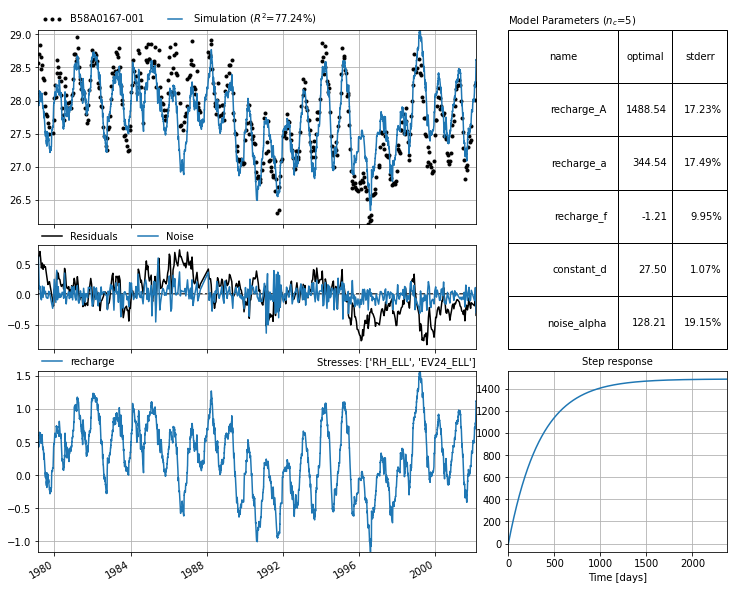

In [ ]:
# results from a single model
ml1 = pstore.get_models("B58A0167-001")
ml1.plots.results()